In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
import matplotlib.ticker as mticker

sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

In [4]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


In [5]:
import sectionate
print(f"Sectionate version: {sectionate.__version__}")

Sectionate version: 0.2.1


In [6]:
from Streamfunctions import *
from Streamfunctions_Sectionate import *

rho0 = 1035. # kg/m3
Sv_s_per_m3 = 1e-6
Sv_s_per_kg = Sv_s_per_m3/rho0

In [12]:
def get_transports(ds):
    return ds[["umo", "vmo", "sigma2_i", "thkcello", "zos"]]

In [59]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        datadir("model/CM4Xp125_budgets_sigma2_2020-2024.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        preprocess = get_transports, 
        engine="zarr")

z_i = np.arange(-6500, 251, 25)
z_l = (z_i[1:] + z_i[0:-1]) / 2
ds = ds.assign_coords({"z_l": z_l, "z_i":z_i})

In [60]:
ds["z"] = approximate_z_on_boundaries_top_down(ds, dim = "sigma2") #should compute from top down
ds["thkcello"] = ds["thkcello"].fillna(0.0)
ds = ds.chunk({"sigma2_l":-1, "sigma2_i":-1, "time":1})
grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")
ds_remap = remap_vertical_coord_custom("z", ds, grid, ds["z"])

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To 

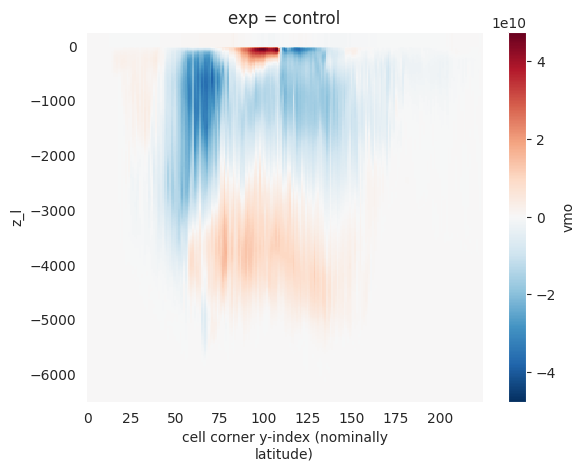

In [61]:
ds_remap["vmo"].mean("time").sum("xh").cumsum("z_l").sel(exp = "control").T.plot()

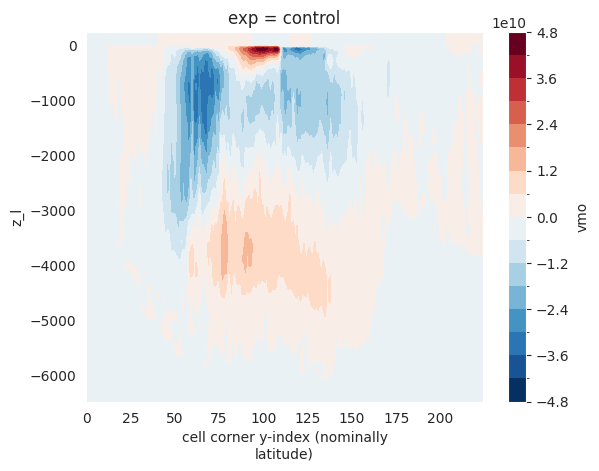

In [62]:
ds_remap["vmo"].mean("time").sum("xh").cumsum("z_l").sel(exp = "control").T.plot.contourf(levels = 20)

In [15]:
def extract_profile_snapshot(ds, grid = None, remapped = True):
    if remapped:
        return ds["vmo"].isel(time = 0, xh = 100, yq = 100)
    else: 
        Z_l = grid.axes["Z"].coords["center"]
        
        ds[f"z_v"] = grid.interp(
            grid.interp(ds["z"], "Y"),
            "Z",
            boundary="extend"
        ).chunk({Z_l: -1})
        ds[f"z_v"] = ds[f"z_v"].where(np.abs(ds[f"vmo"]) >0)
        return ds[["z_v", "vmo"]].isel(time = 0, xh = 100, yq = 100)

ds_transport_snapshot_profile_remapped = extract_profile_snapshot(ds_remap).compute()
ds_transport_snapshot_profile = extract_profile_snapshot(ds, grid = grid, remapped = False).compute()

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


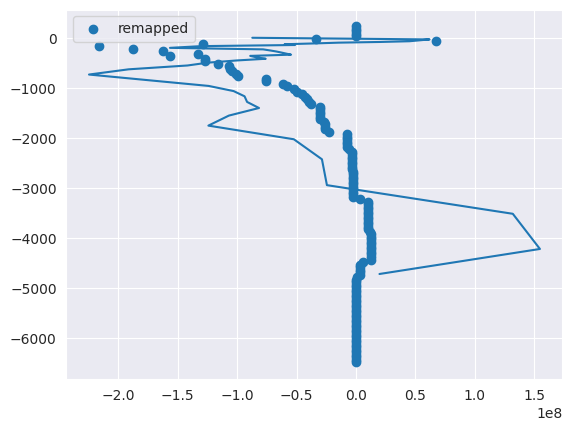

In [16]:
fig, ax = plt.subplots()
ax.scatter(ds_transport_snapshot_profile_remapped.isel(exp = 0), ds_transport_snapshot_profile_remapped["z_l"], label = "remapped")
ax.plot(ds_transport_snapshot_profile["vmo"].isel(exp = 0), ds_transport_snapshot_profile["z_v"].isel(exp = 0))
plt.legend()

In [17]:
ds_transport_snapshot = ds_remap.isel(time = 0).compute()

In [18]:
grid = CM4Xutils.ds_to_grid(ds_transport_snapshot, Zprefix = "z")
moc_indices = generate_moc_grid_indices(grid, dlat=1.)

Processing latitudes:  99%|█████████▉| 176/178 [03:47<00:02,  1.19s/lat]/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/sectionate/section.py:517: RuntimeWarning: invalid value encountered in scalar divide
  return np.arccos(np.clip((np.cos(a) - np.cos(b)*np.cos(c))/(np.sin(b)*np.sin(c)), -1., 1.))
Processing latitudes: 100%|██████████| 178/178 [03:49<00:00,  1.29s/lat]


In [19]:
%%time 
ds_transport = ds_remap.compute()
grid = CM4Xutils.ds_to_grid(ds_transport, Zprefix = "z")

CPU times: user 5min 11s, sys: 6min 32s, total: 11min 44s
Wall time: 1min 15s


In [20]:
%%time 
moc_time_result = moc_across_time(grid, moc_indices, time_dim = "time", 
                                  Z_prefix = "z", reverse_cumsum = False) * Sv_s_per_kg

/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src/Streamfunctions_Sectionate.py:213: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  conv_result = xr.apply_ufunc(
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src/Streamfunctions_Sectionate.py:228: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  thk_result = xr.apply_ufunc(


CPU times: user 1min 37s, sys: 23.7 s, total: 2min 1s
Wall time: 2min 5s


Text(0.5, 1.0, 'Global Streamfunction from Nominal Latitude Bins')

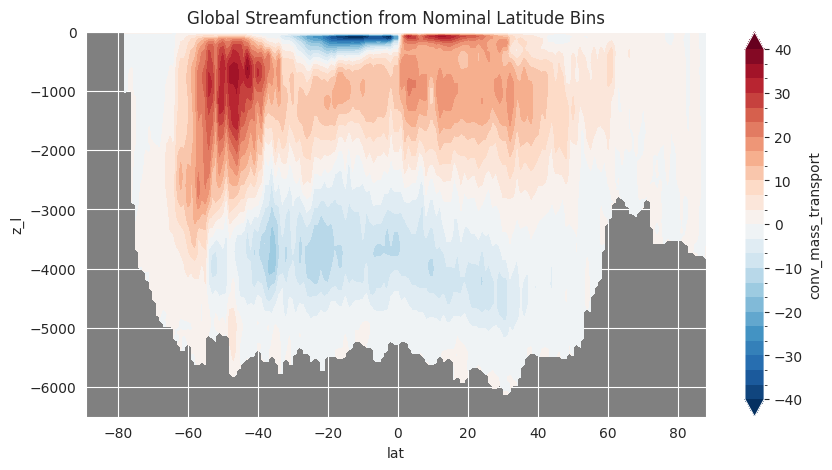

In [65]:
psi_crop =  moc_time_result.mean("time")
psi_crop = psi_crop.where(np.abs(psi_crop) > 0)
# psi_crop = 1e-6 * psi_crop.where(np.abs(psi_crop) > 1).fillna(0.0)

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

levels = np.linspace(-40, 40, 25)

# psi_crop.sel(exp = "control").T.plot.contourf(levels = levels, ax = ax, extend = "both")
psi_crop.sel(exp = "control")["conv_mass_transport"].T.plot.contourf(levels = levels, ax = ax, extend = "both")

ax.set_facecolor('grey')
ax.set_ylim(-6500, 0)
ax.set_title("Global Streamfunction from Nominal Latitude Bins")

Text(0.5, 1.0, 'Global Streamfunction from Nominal Latitude Bins')

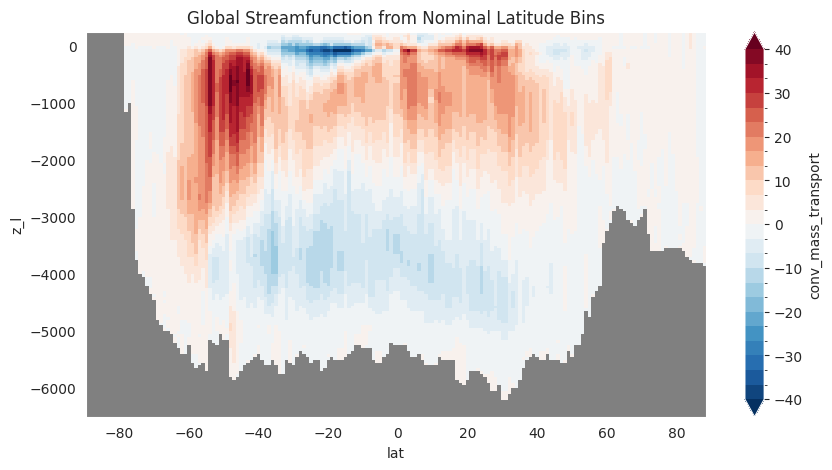

In [94]:
psi_crop =  moc_time_result.mean("time")
# psi_crop = psi_crop.where(np.abs(psi_crop) > 0)
# psi_crop = 1e-6 * psi_crop.where(np.abs(psi_crop) > 1).fillna(0.0)

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

levels = np.linspace(-40, 40, 25)

# psi_crop.sel(exp = "control").T.plot.contourf(levels = levels, ax = ax, extend = "both")
psi_crop.sel(exp = "control").T.plot(levels = levels, ax = ax, extend = "both")

ax.set_facecolor('grey')
ax.set_title("Global Streamfunction from Nominal Latitude Bins")

In [46]:
psi_yearly = psi.groupby("time.year").mean("time")
psi_yearly = psi_yearly.sel(sigma2_l = slice(36, 37.1))

In [47]:
locs = find_min_locations(psi_yearly.isel(exp = 1), fixed_dim = "year")
locs["geolat"] = 0 * locs["yq"]
locs["geolat"].values = psi_yearly["geolat"].sel(yq = locs["yq"]).values
nom_locs = locs["geolat"]

Text(0.5, 1.0, 'Maximum Abyssal Overturning (located at 67°S and sigma2 = 37)')

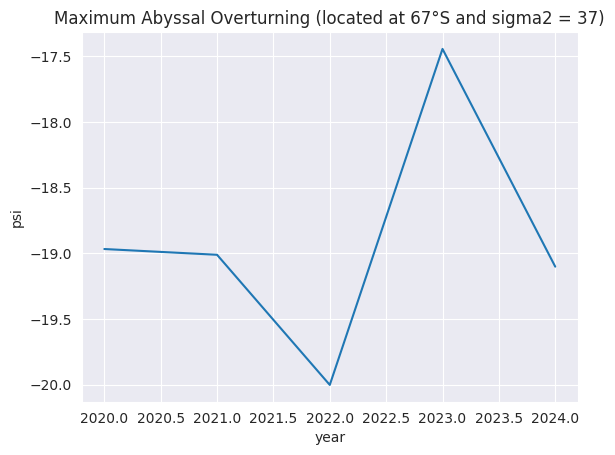

In [48]:
locs = find_min_locations(psi_yearly.isel(exp = 1).mean("year"))

fig, ax = plt.subplots()
(1e-6 * psi_yearly).isel(exp = 1).sel(locs).plot(ax = ax)
ax.set_title("Maximum Abyssal Overturning (located at 67°S and sigma2 = 37)")

In [54]:
locs = find_min_locations(sectionate_psi.sel(sigma2_l = slice(36, 37.1)).isel(exp = 1), fixed_dim = "year")

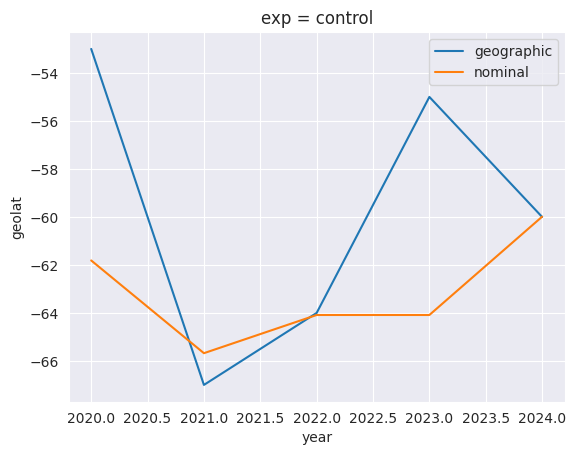

In [55]:
locs["lat"].plot(label = "geographic")
nom_locs.plot(label = "nominal")
plt.legend()